# 1. Data aggregation, summarization and correlation

In this scenario, the data engineer could aggregate and summarize the data to provide insights into the overall trends and patterns in the dataset. For example, they could group the data by some columns (such as VendorID or RatecodeID) and calculate some summary statistics for the numerical columns (such as average fare_amount or total trip_distance). This could involve using Spark's built-in aggregation functions (such as groupBy and agg) to perform these calculations.

The code calculates the average fare amount per month by grouping the DataFrame df by year and month of the lpep_pickup_datetime column. It uses the avg function from the [pyspark.sql.functions](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html) module to calculate the average fare amount and aliases the resulting column as "average_fare". The resulting DataFrame average_fare_per_month is sorted by year and month and is displayed using the display function. Finally, the code saves the results to a new delta table named "average_fare_per_month" using the write function with "delta" format, and "overwrite" mode.

To execute the cell code, use the shortcut CTRL + Enter on Windows, or ⌘ + Enter on MacOS. Alternatively, you can click the 'Run' icon (▶️) located on the left side of the code cell.

## Check the schema for two tables

In [65]:
spark.read.table("green202301").printSchema()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 67, Finished, Available)

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- lpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: integer (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [66]:
spark.read.table("green201501").printSchema()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 68, Finished, Available)

root
 |-- VendorID: long (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: integer (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- trip_type: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)



The schema is the same. We can just parametrize the notebook :) 

In [67]:
table_name  = "green201501"

data_collection = table_name[:-6]  # Extracts all characters except the last six (assumes these are non-digits)
extracted_year = table_name[-6:-2]  # Extracts the four digits representing the year
extracted_month = table_name[-2:]  # Extracts the last two digits representing the month

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 69, Finished, Available)

In [68]:
from pyspark.sql.functions import col, year, month, dayofmonth, avg

df = spark.read.table(table_name)

# Calculate average fare amount per month
average_fare_per_month = (
    df
    .groupBy(year("lpep_pickup_datetime").alias("year"), month("lpep_pickup_datetime").alias("month"))
    .agg(avg("fare_amount").alias("average_fare"))
    .orderBy("year", "month")
)
display(average_fare_per_month)

result_table_name = f"avg_fare_per_month"

# Save the results to a new delta table
average_fare_per_month.write.format("delta").mode("overwrite").saveAsTable(f"silvercleansed.{result_table_name}")

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 70, Finished, Available)

SynapseWidget(Synapse.DataFrame, 9322a18a-d74e-4ebc-b89f-a99c75348cb3)

### Refresh Lakehouse explorer

## Exploratory data analysis (EDA)



In this scenario, the data engineer could perform some data cleaning and transformation tasks to prepare the data for downstream analysis. 

Objective: **Cleanse the data and filter out invalid records for further analysis.**

In this scenario, we aim to demonstrate how data engineers can perform data cleansing and filtering on a large dataset. We begin by loading the data from the source and then filter out records where the trip distance and fare amount are less than or equal to zero, which are invalid records.

Next, we cleanse the data by converting the `store_and_fwd_flag` column to a boolean type, and converting the `lpep_pickup_datetime` and `lpep_dropoff_datetime` columns to timestamp types. Finally, we write the cleansed data to the destination in the parquet format.

This scenario demonstrates the importance of data cleansing and filtering to ensure the data is accurate and valid before proceeding with further analysis.

In [69]:
from pyspark.sql.functions import col, when

# Load data from source
df = spark.read.load(f"Tables/{table_name}", header=True, inferSchema=True)
df_count = df.count()

# Remove invalid records
df = df.filter((col("trip_distance") > 0) & (col("fare_amount") > 0))
df_count_after_clearning = df.count()

number_of_deleted_records = df_count - df_count_after_clearning

print(f"Removed {number_of_deleted_records} records")

# # Cleanse data
df = df.withColumn("store_and_fwd_flag", when(col("store_and_fwd_flag") == "Y", True).otherwise(False))
df = df.withColumn("lpep_pickup_datetime", col("lpep_pickup_datetime").cast("timestamp"))
df = df.withColumn("lpep_dropoff_datetime", col("lpep_dropoff_datetime").cast("timestamp"))

# Display cleansed data to destination
display(df)

# Write cleansed data to destination
df.write.format("delta").mode("overwrite").saveAsTable(f"silvercleansed.{table_name}_cleansed")

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 71, Finished, Available)

Removed 28696 records


SynapseWidget(Synapse.DataFrame, a953bd4f-8a7c-409f-897e-205f06030ef6)


Exploratory data analysis (EDA) is a common scenario for data engineers. EDA is the process of analyzing and understanding data to gain insights, identify patterns, and develop hypotheses for further investigation. In data engineering, EDA is often done to identify data quality issues, anomalies, or other problems that need to be addressed before data can be used for analysis or modeling. EDA can also help data engineers to understand the relationships between different data sources and determine the best way to join or transform them.

`df.count()` is a Spark DataFrame API function that returns the number of rows in the DataFrame. It is a convenient way to quickly determine the size of the DataFrame without having to iterate over all the rows manually. The function is an action in Spark, meaning it triggers a computation that counts the number of rows in the DataFrame and returns the result. It is useful for getting a quick overview of the data size and checking if any rows are missing or dropped during data processing. However, it should be used with caution on large datasets, as it can be a costly operation that requires significant computational resources.

In [73]:
# Load data from source
df = spark.sql("SELECT * FROM silvercleansed.green201501_cleansed")

# Count the number of rows 
df.count()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 75, Finished, Available)

1479797

`df.dtypes` is an attribute of a DataFrame object that returns a list of tuples containing the column names and their corresponding data types. The data types are represented using the Spark SQL DataType class, which is a set of classes for representing data types in Spark SQL.

In [74]:
# Display the data types of the columns.

df.dtypes

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 76, Finished, Available)

[('VendorID', 'bigint'),
 ('lpep_pickup_datetime', 'timestamp'),
 ('lpep_dropoff_datetime', 'timestamp'),
 ('store_and_fwd_flag', 'boolean'),
 ('RatecodeID', 'bigint'),
 ('PULocationID', 'bigint'),
 ('DOLocationID', 'bigint'),
 ('passenger_count', 'bigint'),
 ('trip_distance', 'double'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('ehail_fee', 'int'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('payment_type', 'bigint'),
 ('trip_type', 'double'),
 ('congestion_surcharge', 'int')]

The code imports the col function from `pyspark.sql.functions` and uses it to select the `"vendorID"` column from the Spark DataFrame `df`. The `groupBy()` function is then called on the resulting column object to group the DataFrame by the distinct values in the `"vendorID"` column. The `count()` function is then applied to the resulting grouped DataFrame to calculate the number of records in each group. Finally, the `show()` function is used to display the resulting DataFrame on the console.

In [75]:
# Group the data by 'VendorID' and count the number of rows in each group. 

from pyspark.sql.functions import col

df.groupBy(col("VendorID")).count().show()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 77, Finished, Available)

+--------+-------+
|VendorID|  count|
+--------+-------+
|       1| 326508|
|       2|1153289|
+--------+-------+



The code reads the Spark DataFrame `df` which contains information about NYC taxi trips. The code uses the `'min'` and `'max'` functions from PySpark to select the earliest and latest pickup dates respectively. These dates are stored in the variables `'oldest_day'` and `'latest_day'`. The `'collect'` function is then used to retrieve these values and they are printed to the console using the `'print'` function. The output displays the earliest and latest pickup dates in the dataset.

In [76]:
# Retrieve information about the earliest and latest pickup dates in the dataset.

from pyspark.sql.functions import min, max

oldest_day = df.select(min("lpep_pickup_datetime")).collect()[0][0]
latest_day = df.select(max("lpep_dropoff_datetime")).collect()[0][0]

print("Oldest pickup date: ", oldest_day)
print("Latest pickup date: ", latest_day)

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 78, Finished, Available)

Oldest pickup date:  2015-01-01 00:00:00
Latest pickup date:  2015-02-01 23:48:50


This code uses the PySpark `date_format` function to group the `df` DataFrame by the year, month, and day of the `lpep_pickup_datetime` column, and then counts the number of occurrences for each date.

`date_format` is a PySpark SQL function used to format the date or timestamp column to the specified format. In this code, the format used is `yyyy-MM-dd`. The alias `pickup_date` is assigned to the formatted date column, and the DataFrame is grouped by this column using the `groupby()` method. The `count()` method is then applied to count the number of occurrences of each pickup_date. Finally, the result is displayed using the `show()` method.

In [77]:
from pyspark.sql.functions import date_format

# group by year, month and day of lpepPickupDatetime
df_grouped = df.groupby(date_format('lpep_pickup_datetime', 'yyyy-MM-dd').alias('pickup_date')).count()

# show the result
df_grouped.show()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 79, Finished, Available)

+-----------+-----+
|pickup_date|count|
+-----------+-----+
| 2015-01-18|54191|
| 2015-01-21|42406|
| 2015-01-10|63233|
| 2015-01-05|40959|
| 2015-01-26|29197|
| 2015-01-01|61902|
| 2015-01-24|57707|
| 2015-01-27|15083|
| 2015-01-14|43432|
| 2015-01-06|39800|
| 2015-01-15|46955|
| 2015-01-30|61838|
| 2015-01-08|46804|
| 2015-01-29|46986|
| 2015-01-12|40030|
| 2015-01-31|69585|
| 2015-01-16|58771|
| 2015-01-23|53878|
| 2015-01-11|49559|
| 2015-01-04|40905|
+-----------+-----+
only showing top 20 rows



This code computes the minimum and maximum values of the fare_amount column in the Spark DataFrame df. It uses the `min()` and `max()` functions from the `pyspark.sql.functions` module to compute the minimum and maximum values, respectively. The `alias()` method is used to rename the resulting columns as `"min"` and `"max"`. Finally, the `show()` method is used to display the resulting DataFrame with two columns `"min"` and `"max"`, showing the minimum and maximum values of the `fare_amount column`.

In [78]:
# min max values of target feature "fare_amount"

df.select(min('fare_amount').alias('min'), max('fare_amount').alias('max')).show()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 80, Finished, Available)

+----+-----+
| min|  max|
+----+-----+
|0.01|800.0|
+----+-----+



This code is performing descriptive statistical analysis on the `"fare_amount"` column of a Spark DataFrame named `"df"`. Specifically, it is using the `describe()` method of the DataFrame to compute summary statistics including `count`, `mean`, `standard deviation`, `minimum`, and `maximum`.

The result of `describe()` is then converted to a Pandas DataFrame using the `toPandas()` method. This allows the statistics to be displayed in a more user-friendly table format, which includes the same summary statistics along with the 25th, 50th, and 75th percentiles. The resulting table provides insights into the central tendency and dispersion of the `"fare_amount"` variable, and can be useful for understanding the distribution of the data and identifying potential outliers.

In [79]:
# General statistical characteristics of fare amount

df.select('fare_amount').describe().toPandas()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 81, Finished, Available)

,summary,fare_amount
0,count,1479797
1,mean,11.784288608505024
2,stddev,8.980312963874029
3,min,0.01
4,max,800.0


This code computes the approximate quantiles of the `'fare_amount'` column of the DataFrame `'df'` using the `'approxQuantile'` function from PySpark's SQL functions module. The function takes three arguments - the name of the column for which quantiles are to be computed, the list of quantile values to be returned, and a relative error value. In this case, the quantiles are 0.1, 0.25, 0.5, 0.75, and 0.9, and the relative error is set to 0.01. The function returns an array of approximate quantile values for the given column and quantile values.

In [80]:
# quantiles

df.select('fare_amount').approxQuantile("fare_amount",[0.1, 0.25, 0.5, 0.75, 0.9], 0.01)

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 82, Finished, Available)

[5.0, 6.5, 9.0, 14.5, 22.0]

This code is used to plot the distribution of fare_amount using matplotlib library in Python. The fare_amount data is first extracted from the Spark DataFrame using the select function along with the F.col() function to extract the fare_amount column. The resulting DataFrame is then converted to a Pandas DataFrame using the toPandas() function. The fare_amount data is then plotted as a histogram using the hist() function from matplotlib. The number of bins for the histogram is set to 50 using the bins parameter. Finally, the title and axis labels for the plot are set using the title(), xlabel(), and ylabel() functions, and the plot is displayed using the show() function.

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 83, Finished, Available)

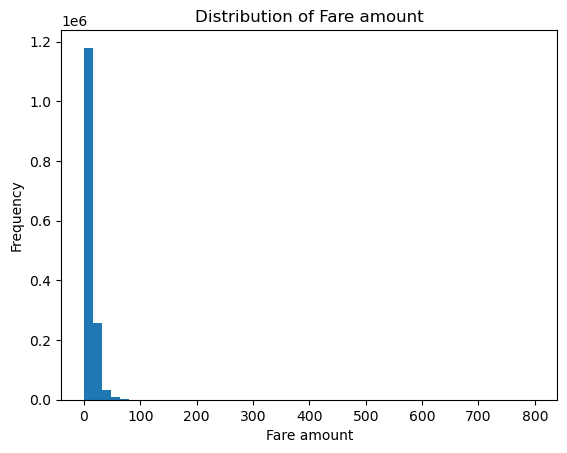

In [81]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Assuming your DataFrame is named `df`
fare_distribution = df.select(F.col('fare_amount')).toPandas()

# Plot histogram
plt.hist(fare_distribution, bins=50)
plt.title('Distribution of Fare amount')
plt.xlabel('Fare amount')
plt.ylabel('Frequency')
plt.show()

## Scatter chart

This code snippet demonstrates how to create a scatter plot using Matplotlib in Python. The code assumes that the Spark DataFrame df contains the columns fare_amount and trip_distance. First, the Spark DataFrame is converted to a Pandas DataFrame using the toPandas() function. Then, a scatter plot is created using ax.scatter() function. The x and y arguments of the scatter() function represent the variables to be plotted on the x- and y-axes, respectively. The alpha argument controls the transparency of the points in the scatter plot. The axis labels and title are set using the ax.set_xlabel(), ax.set_ylabel(), and ax.set_title() functions. Finally, the plot is displayed using the plt.show() function. This code can be used to visualize the correlation between fare amount and trip distance in the DataFrame.

To execute the cell code, use the shortcut CTRL + Enter on Windows, or ⌘ + Enter on MacOS. Alternatively, you can click the 'Run' icon (▶️) located on the left side of the code cell.

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 84, Finished, Available)

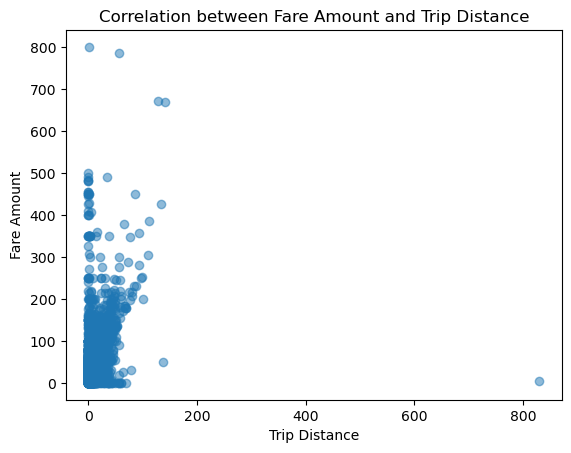

In [82]:
import matplotlib.pyplot as plt

# convert Spark DataFrame to Pandas DataFrame
df_pd = df.select(['fare_amount', 'trip_distance']).toPandas()

# create scatter plot
fig, ax = plt.subplots()
ax.scatter(x=df_pd['trip_distance'], y=df_pd['fare_amount'], alpha=0.5)

# set axis labels and title
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Fare Amount')
ax.set_title('Correlation between Fare Amount and Trip Distance')

# show the plot
plt.show()


# 2. Custom libraries & advanced visualisation

Libraries provide reusable code that Data Engineers may want to include in their Spark application. Each workspace comes with a pre-installed set of libraries available in the Spark run-time and available to be used immediately in the notebook or Spark job definition.  Based on the user scenarios and specific needs, you can include other libraries. There are two types of libraries you may want to include:
- Feed library: Feed libraries are the ones that come from public sources or repositories. You can install Python feed libraries from PyPI and Conda by specifying the source in the Library Management portals. You can also use a Conda environment specification .yml file to install libraries.
- Custom library: Custom libraries are the code built by you or your organization. .whl, .jar and .tar.gz can be managed through Library Management portals. Note that .tar.gz is only supported for R language, please use .whl for Python custom libraries.

## Install library

The code line `pip install altair` is used to install the Python package "Altair" via the package manager "pip". Altair is a library for creating interactive visualizations in Python.

"Pip" is a package manager for Python that allows users to easily install, manage, and update Python packages (libraries) from the Python Package Index (PyPI) and other package repositories. Pip can be used to install packages globally on the system or locally in a specific virtual environment.



In [83]:
pip install altair

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 85, Finished, Available)

Note: you may need to restart the kernel to use updated packages.


## Create custom visualisation with a new library

First, the code imports the Altair library using the alias "alt". Next, the code uses Spark SQL to select all columns from the "NYC_Taxi_cleansed" table in the "Bronze" database, limiting the result to the first 5000 rows. The resulting DataFrame is then converted to a Pandas DataFrame using the toPandas method.

The alt.Chart method is then called with the Pandas DataFrame as the data source, and the mark_point method is used to specify that the chart should use points as the visual mark. The encode method is then used to specify the encoding for the x-axis, y-axis, and color of the points, as well as the tooltip values. The x-axis is mapped to the "tripDistance" column, the y-axis is mapped to the "fareAmount" column, and the color of the points is mapped to the "paymentType" column, which is treated as a categorical variable. The tooltip displays the "tripDistance", "fareAmount", and "paymentType" columns for each point.

Finally, the interactive method is called to enable interactivity in the resulting visualization, allowing the user to zoom, pan, and view tooltip information when hovering over points in the scatter plot.

In [84]:
import altair as alt

df = spark.sql(f"SELECT * FROM bronzerawdata.{table_name} LIMIT 5000")

data = df.toPandas()

alt.Chart(data).mark_point().encode(
    x='trip_distance',
    y='fare_amount',
    color='payment_type:N',
    tooltip=['trip_distance', 'fare_amount', 'payment_type']
).interactive()

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 86, Finished, Available)

alt.Chart(...)

# 3. Shortcuts and final table

Shortcuts in a lakehouse allow users to reference data without copying it. It unifies data from different lakehouses, workspaces, or external storage, such as ADLS Gen2 or AWS S3. You can quickly make large amounts of data available in your lakehouse locally without the latency of copying data from the source.

## Load new data


In [85]:
df = spark.read.format("csv").option("header","true").load("Files/NYC-Taxi-Discounts-Per-Day.csv")
# df now is a Spark DataFrame containing CSV data from "Files/Generated-NYC-Taxi-Green-Discounts.csv".
display(df)

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 87, Finished, Available)

SynapseWidget(Synapse.DataFrame, 7d105745-96dd-4994-b3d7-ae054a5df021)

## Unpivot sideloaded data

The import pandas as pd line imports the Pandas library and assigns it an alias pd.

Melt the discounts DataFrame: The pd.melt() function is used to convert the discouts_df PySpark DataFrame to a long format by converting date columns into rows. First, discouts_df.toPandas() is used to convert the PySpark DataFrame to a Pandas DataFrame. Then, pd.melt() takes the Pandas DataFrame, uses 'VendorID' as the identifier variable (id_vars), sets the 'date' as the variable name (var_name), and 'discount' as the value name (value_name). The melted DataFrame is stored in discouts_pd_df.

Convert the melted DataFrame to a PySpark DataFrame: The spark.createDataFrame() function is used to convert the melted Pandas DataFrame discouts_pd_df back to a PySpark DataFrame, which is stored in the discounts_spark_df variable.

In [86]:
import pandas as pd

# Melt discouts_df to long format
discouts_pd_df = pd.melt(df.toPandas(), id_vars=['VendorID'], var_name='date', value_name='discount')

discounts_spark_df = spark.createDataFrame(discouts_pd_df)

display(discounts_spark_df)

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 88, Finished, Available)

SynapseWidget(Synapse.DataFrame, eaf60709-78f0-492e-8dc0-f8a73414bde3)

## Prepare data for join

In [87]:
from pyspark.sql.functions import to_date

nyc_taxi_df = spark.sql(f"SELECT * FROM bronzerawdata.{table_name}")

nyc_taxi_df = nyc_taxi_df.withColumn("date", to_date("lpep_pickup_datetime"))

display(nyc_taxi_df)

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 89, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8bf4b834-0f4f-4289-a5a6-340ae21740ad)

## Join two datasets and save result

In [88]:
from pyspark.sql.functions import col

# Create aliases for your DataFrames
df1_alias = nyc_taxi_df.alias("df1")
df2_alias = discounts_spark_df.alias("df2")

# Define the join condition using the aliases
join_condition = [col("df1.VendorID") == col("df2.VendorID"), col("df1.date") == col("df2.date")]

# Perform the join using the aliases
result_df = df1_alias.join(df2_alias, join_condition, how='inner')  # You can use other join types like 'left', 'right', 'outer', etc.

# Select only the desired columns
result_df = result_df.select("df1.VendorID", "df1.lpep_pickup_datetime", "df2.discount")

display(result_df)

# Save the results to a new delta table
result_df.write.format("delta").mode("overwrite").saveAsTable(f"silvercleansed.{table_name}_discounts")

StatementMeta(, 7d1a68b0-dcb4-4057-9d7b-f4abbf6c7fff, 90, Finished, Available)

SynapseWidget(Synapse.DataFrame, 58d89df9-7646-42fd-92f1-dfa3fe4d402b)

## Refresh Lakehouse explorer  

# Now, continue with automation by proceeding to the next task (Exercise 2, Task 2.8)
